In [1]:
import os
# Define the root directory of the dataset
narratives_root = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives"

# Collect potential derivative subdirectories for exploration
derivatives_path = os.path.join(narratives_root, "derivatives")
possible_dirs = []

for root, dirs, files in os.walk(derivatives_path):
    for d in dirs:
        if "fsaverage" in d or "surf" in d or "gii" in d:
            possible_dirs.append(os.path.join(root, d))

possible_dirs[:10]  # Display only first 10 results

['/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/fsaverage',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/fsaverage6',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/fsaverage5',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/sub-021/surf',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/sub-330/surf',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/sub-133/surf',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/sub-301/surf',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/sub-333/surf',
 '/home/iustin/predictive-coding-for-fMRI-LM-align-speech

In [2]:
!ls /home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/freesurfer/fsaverage

label  mri  mri.2mm  scripts  surf  xhemi


In [3]:
!ls /home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-nosmooth/

group_roi-EAC_desc-exclude_isc.json		    sub-172
group_roi-EAC_desc-exclude_lags.json		    sub-173
group_roi-EAC_isc.json				    sub-174
group_roi-EAC_lags.json				    sub-175
group_space-fsaverage6_hemi-L_desc-median_tsnr.gii  sub-176
group_space-fsaverage6_hemi-R_desc-median_tsnr.gii  sub-177
sub-001						    sub-178
sub-002						    sub-179
sub-003						    sub-180
sub-004						    sub-181
sub-005						    sub-182
sub-006						    sub-183
sub-007						    sub-184
sub-008						    sub-185
sub-009						    sub-186
sub-010						    sub-187
sub-011						    sub-188
sub-012						    sub-189
sub-013						    sub-190
sub-014						    sub-191
sub-015						    sub-192
sub-016						    sub-193
sub-017						    sub-194
sub-018						    sub-195
sub-019						    sub-196
sub-020						    sub-197
sub-021						    sub-198
sub-022						    sub-199
sub-023						    sub-200
sub-024						    sub-201
sub-025						    sub-202
sub-026						    sub-203
sub-027						    sub-204
sub-028						    sub-205
sub-

In [4]:
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import os

class SurfaceBOLDGiiDataset(Dataset):
    """
    PyTorch Dataset for fsaverage6 surface-projected BOLD time series (.func.gii).
    """

    def __init__(self, base_dir, subject, task, hemisphere_order=("L", "R")):
        """
        Args:
            base_dir (str): Path to derivatives/afni-nosmooth/
            subject (str): Subject ID (e.g., "021")
            task (str): Task name (e.g., "pieman")
            hemisphere_order (tuple): Hemisphere order to concatenate ("L", "R")
        """
        self.subject = subject
        self.task = task
        self.hemi_paths = []

        for hemi in hemisphere_order:
            fname = f"sub-{subject}_task-{task}_space-fsaverage6_hemi-{hemi}_desc-clean.func.gii"
            fpath = os.path.join(base_dir, f"sub-{subject}", "func", fname)
            if not os.path.exists(fpath):
                raise FileNotFoundError(f"Missing file: {fpath}")
            self.hemi_paths.append(fpath)

        # Load and cache the full surface data (T, V)
        self.hemi_data = [
            np.array([d.data for d in nib.load(path).darrays])
            for path in self.hemi_paths
        ]
        self.full_data = np.hstack(self.hemi_data)  # shape (T, V_total)

    def __len__(self):
        return self.full_data.shape[0]  # Number of TRs

    def __getitem__(self, idx):
        return self.full_data[idx]  # shape: (V_total,)

base_dir = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-nosmooth"
# test for a subject and task
dataset = SurfaceBOLDGiiDataset(base_dir=base_dir, subject="021", task="pieman")

print(len(dataset))           # Number of TRs
print(dataset[0].shape)       # Shape: (vertices,)

300
(81924,)


In [5]:
import os
from glob import glob
from collections import defaultdict
import pandas as pd

# Root directory where the dataset is located
bids_root = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives"
derivatives_path = os.path.join(bids_root, "derivatives", "afni-nosmooth")

# Tasks of interest
tasks = ["lucy", "milkyway", "pieman"]

# Data structure to collect found files
found_surface_files = defaultdict(dict)

# Search across all subjects and hemispheres
for task in tasks:
    for hemi in ["L", "R"]:
        pattern = os.path.join(
            derivatives_path,
            "sub-*",
            "func",
            f"sub-*_task-{task}_space-fsaverage6_hemi-{hemi}_desc-clean.func.gii"
        )
        matches = glob(pattern)
        for match in matches:
            # Extract subject ID from the filename
            basename = os.path.basename(match)
            subject = basename.split("_")[0].replace("sub-", "")
            if subject not in found_surface_files:
                found_surface_files[subject] = {}
            if task not in found_surface_files[subject]:
                found_surface_files[subject][task] = {}
            found_surface_files[subject][task][hemi] = match

# Convert to a readable table
records = []
for subj, task_dict in found_surface_files.items():
    for task, hemi_dict in task_dict.items():
        row = {
            "subject": subj,
            "task": task,
            "L_path": hemi_dict.get("L", None),
            "R_path": hemi_dict.get("R", None),
        }
        records.append(row)

df = pd.DataFrame(records)

subject_task_list = list(df[['subject', 'task']].itertuples(index=False, name=None))
base_dir = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-nosmooth"

all_entries = []
for subject, task in subject_task_list:
    lh_path = os.path.join(base_dir, f"sub-{subject}", "func",
                            f"sub-{subject}_task-{task}_space-fsaverage6_hemi-L_desc-clean.func.gii")
    rh_path = os.path.join(base_dir, f"sub-{subject}", "func",
                            f"sub-{subject}_task-{task}_space-fsaverage6_hemi-R_desc-clean.func.gii")

    if not (os.path.exists(lh_path) and os.path.exists(rh_path)):
        continue

    lh_data = np.array([d.data for d in nib.load(lh_path).darrays])
    rh_data = np.array([d.data for d in nib.load(rh_path).darrays])
    full_data = np.hstack([lh_data, rh_data])  # (T, V)

    for t in range(full_data.shape[0]):
        all_entries.append({
            "subject": subject,
            "task": task,
            "TR": t,
            "bold": full_data[t]
        })

df_entries = pd.DataFrame(all_entries)
# print(df_entries.head(), df_entries.shape)
for task in tasks:
    print(f"Number of entries for task '{task}': {df[df[f'task'] == f'{task}']['subject'].nunique()}")

Number of entries for task 'lucy': 16
Number of entries for task 'milkyway': 53
Number of entries for task 'pieman': 68


In [29]:
import torch
from transformers import AutoTokenizer, GPT2Model
import numpy as np
import os
from tqdm import tqdm

from model.embeddings import get_gpt2_embeddings
import pandas as pd
import pickle


# ======== Pre-trained GPT-2 ========
class DataParams:
    def __init__(self, embedding_layer=12): # final embedding layer
        self.embedding_layer = embedding_layer

# === Define task list ===
tasks = ["lucy", "milkyway","pieman"]

# === Path setup ===
gentle_root = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/stimuli/gentle"
output_dir = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_vanilla_representations"
os.makedirs(output_dir, exist_ok=True)

# === Run for each task ===
for task in tasks:
    print(f"\nProcessing task: {task}")
    gentle_task = "milkywayoriginal" if task == "milkyway" else task
    transcript_path = os.path.join(gentle_root, gentle_task, "align.csv")

    if not os.path.exists(transcript_path):
        print(f"Skipping {task} — file not found: {transcript_path}")
        continue

    # Load transcript
    df = pd.read_csv(transcript_path, names=["word_orig", "word", "onset", "offset"]).dropna().reset_index(drop=True)
    df["transcript_idx"] = df.index # Add index for transcript
    # Create 8-word sliding windows
    window_size = 8
    windows = []
    sentence_id = 0
    for i in range(len(df) - window_size + 1):
        df["transcript_idx"] = df.index
        window = df.iloc[i:i+window_size].copy()
        window["word_idx"] = list(range(window_size))
        window["sentence_id"] = sentence_id
        window["transcript_idx"] = df["transcript_idx"].iloc[i:i+window_size].to_list()
        windows.append(window)
        sentence_id += 1

    df_contextual = pd.concat(windows, ignore_index=True)
    window_to_word = df_contextual[df_contextual.word_idx == window_size // 2]["transcript_idx"].tolist()

    # Compute embeddings
    data_params = DataParams(embedding_layer=12)
    embeddings = get_gpt2_embeddings(df_contextual, data_params)

    # Save
    save_path = os.path.join(output_dir, f"representations_gpt2_ws8_{task}.pkl")
    with open(save_path, "wb") as f:
        pickle.dump({"ws_8": embeddings}, f)

    print(f"Saved: {save_path}")


# ========== Fine-tuned GPT-2  ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("gpt2")


checkpoint_path = '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/runs/gpt2_alpha_05/checkpoint-19306'
model = GPT2Model.from_pretrained(checkpoint_path, output_hidden_states=True).to(device)
# activations_path = os.path.join(checkpoint_path, "activations/eval_activations.pt")
# data = torch.load(activations_path, map_location="cpu")
# logits, activations = data['logits'], data['activations']
model.eval()

output_dir = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_ft_representations"
os.makedirs(output_dir, exist_ok=True)

tasks = ["lucy", "milkyway", "pieman"]

# === Utility ===
def get_forecast_window_embeddings(text_tokens, layer, d, window_size=7):
    """
    Extract forecast window of 7 tokens ending at offset d for each central word.
    """
    activations = []

    for i in range(len(text_tokens)):
        idx = i + d
        start = idx - window_size + 1
        end = idx + 1
        if start < 0 or end > len(text_tokens):
            continue
        window = text_tokens[start:end]
        tokens = tokenizer(" ".join(window), return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**tokens)
        h = outputs.hidden_states[layer]  # [1, seq_len, hidden_dim]
        rep = h.mean(dim=1).squeeze().cpu().numpy()
        activations.append(rep)
    return np.array(activations)

# === Parameters ===
# The distance d from the current word to the window endpoint.
# Negative values use past context, positive values use future context.
forecast_distances = list(range(-4, 5))  # [-4, -3, -2, -1, 0, 1]()_
# Number of words in the forecast window
# The paper uses 7 successive words, so:
window_size = 7

# The layer of the language model to extract activations from
# The paper uses layer 8 (0-indexed), which corresponds to the 9th Transformer block in GPT-2.
layer_to_use = 8

# === Main loop ===
for task in tasks:
    print(f"\nProcessing task: {task}")
    gentle_task = "milkywayoriginal" if task == "milkyway" else task
    transcript_path = os.path.join(gentle_root, gentle_task, "align.csv")

    if not os.path.exists(transcript_path):
        print(f"Skipping {task} — file not found: {transcript_path}")
        continue

    df = pd.read_csv(transcript_path, names=["word_orig", "word", "onset", "offset"]).dropna().reset_index(drop=True)
    text_tokens = df["word"].tolist()

    task_result = {}
    for d in tqdm(forecast_distances):
        X_tilde_d = get_forecast_window_embeddings(text_tokens, layer=layer_to_use, d=d, window_size=window_size)
        task_result[f"d={d}"] = X_tilde_d

    with open(os.path.join(output_dir, f"forecast_layer{layer_to_use}_{task}.pkl"), "wb") as f:
        pickle.dump(task_result, f)

    print(f"Saved forecast windows for task '{task}' at: {output_dir}")


Processing task: lucy
Saved: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_vanilla_representations/representations_gpt2_ws8_lucy.pkl

Processing task: milkyway
Saved: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_vanilla_representations/representations_gpt2_ws8_milkyway.pkl

Processing task: pieman
Saved: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_vanilla_representations/representations_gpt2_ws8_pieman.pkl

Processing task: lucy


100%|██████████| 9/9 [00:43<00:00,  4.79s/it]


Saved forecast windows for task 'lucy' at: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_ft_representations

Processing task: milkyway


100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


Saved forecast windows for task 'milkyway' at: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_ft_representations

Processing task: pieman


100%|██████████| 9/9 [00:26<00:00,  2.89s/it]

Saved forecast windows for task 'pieman' at: /home/iustin/predictive-coding-for-fMRI-LM-align-speech/gpt2_ft_representations


# Brain Score

computed for each tasks across all subjects, PCA reduced

In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import nilearn.image
import nilearn.masking
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

def make_fir_embeddings(vectors, transcript, window_to_word, fir_delays=6):
    """
    Builds FIR (Finite Impules Response) expanded embeddings. 
    From the paper, Brain Scores section: "we modelled the slow bold response thanks to a finite impulse response (FIR) model with six delays (from 0 to 9s, TR=1.5s)

    Args:
        vectors: np.ndarray of shape (num_windows, d)
        transcript: DataFrame with at least `TR_onset` column
        window_to_word: list of len=num_windows with row indices into `transcript`
        fir_delays: number of TR delays (e.g., 6 for delays 0 to 9s)

    Returns:
        X_fir: np.ndarray of shape (num_valid_TRs, fir_delays * d)
        valid_TRs: list of valid TRs used in the result
    """
    vectors = np.asarray(vectors)
    d = vectors.shape[1]

    # Map each window embedding to its TR onset
    TRs = transcript.iloc[window_to_word].TR_onset.to_numpy()

    # Build dict: TR -> list of vector indices
    from collections import defaultdict
    tr_to_idx = defaultdict(list)
    for i, tr in enumerate(TRs):
        tr_to_idx[int(tr)].append(i)

    X_fir = []
    valid_TRs = []

    for tr in sorted(tr_to_idx.keys()):
        concat = []
        valid = True
        for delay in range(fir_delays):
            tr_d = tr - delay
            if tr_d in tr_to_idx:
                idxs = tr_to_idx[tr_d]
                concat.append(vectors[idxs].mean(axis=0))
            else:
                valid = False
                break
        if valid:
            fir_embed = np.concatenate(concat[::-1])  # delay 0 first
            X_fir.append(fir_embed)
            valid_TRs.append(tr)

    return np.stack(X_fir), np.array(valid_TRs)


TR = 1.5
REDUCE_VOXELS = False  # whether to reduce the number of voxels using PCA
base_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech"
results_all_models_per_subs = []

for task in ["lucy", "milkyway", "pieman"]:
    participants = pd.read_table(f"{base_path}/narratives/participants.tsv")

    if task == "pieman":
        pieman_spec = {
            "exclude": ["001", "013", "014", "021", "022", "038", "056", "068", "069"],
            "two_sessions": ["002", "003", "004", "005", "006", "008", "010", "011", "012", "015", "016"],
        }
        participants_in_task = [
            participants.participant_id[i]
            for i in range(len(participants))
            if task in participants.task[i] and "piemanpni" not in participants.task[i]
        ]
    else:
        participants_in_task = [
            participants.participant_id[i]
            for i in range(len(participants))
            if task in participants.task[i]
        ]

    if task == "milkyway":
        participants_in_task = [
            participants.participant_id[i]
            for i in range(len(participants))
            if task in participants.task[i] and "original" in participants.condition[i]
        ]
        vars = ['milkywayoriginal', 'milkywayvodka', 'milkywaysynonyms']
    else:
        vars = [task]

    subs = [a.split("-")[1] for a in participants_in_task]

    with open(f"{base_path}/narratives/code/scan_exclude.json", "r") as j:
        subs_exc = json.load(j)
    subs = [s for s in subs if s not in [a.split("-")[1] for a in subs_exc[task].keys()]]

    with open(f"{base_path}/gpt2_vanilla_representations/representations_gpt2_ws8_{task}.pkl", "rb") as f:
        vectors_ = pickle.load(f)
    embeddings = vectors_["ws_8"]

    for sub in subs:
        print(f"Processing subject {sub} - task {task}")
        task_ = "pieman_run-1" if (task == "pieman" and sub in pieman_spec["two_sessions"]) else task

        for var in vars:
            transcript_path = f"{base_path}/narratives/stimuli/gentle/{var}/align.csv"
            if not os.path.exists(transcript_path):
                continue
            transcript = pd.read_csv(transcript_path, names=["word_orig", "word", "onset", "offset"]).dropna().reset_index(drop=True)

            events_path = f"{base_path}/narratives/sub-{sub}/func/sub-{sub}_task-{task_}_events.tsv"
            if not os.path.exists(events_path):
                continue
            onset = pd.read_table(events_path).onset[0]

            transcript["TR_onset"] = ((onset + transcript.onset) // TR).astype(int)
            transcript["TR_offset"] = ((onset + transcript.offset) // TR).astype(int)

            try:
                img_path = f"{base_path}/narratives/derivatives/afni-nosmooth/sub-{sub}/func/sub-{sub}_task-{task_}_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz"
                mask_path = f"{base_path}/narratives/derivatives/afni-smooth/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-{task}_desc-brain_mask.nii.gz"
                roi_path =  f"{base_path}/narratives/derivatives/afni-nosmooth/sub-{sub}/func/sub-{sub}_task-{task_}_space-fsaverage6_hemi-L_desc-clean.func.gii"
                img = nilearn.image.load_img(img_path)
                mask = nilearn.image.load_img(mask_path)
                bold = nilearn.masking.apply_mask(img, mask)
            except Exception as e:
                print(f"Skipping sub-{sub} due to error: {e}")
                continue

            X_fir, valid_TRs = make_fir_embeddings(embeddings, transcript, window_to_word, fir_delays=6)
            if len(valid_TRs) == 0:
                continue

            Y_not_used = bold[[int(tr) for tr in valid_TRs]] # T (time-points;n_samples) x 52422 (voxels)
        
            Y = PCA(n_components=20).fit_transform(Y_not_used)  # T x 50
            print(f"Subject {sub} - task {task} - variant {var}: X_fir shape: {X_fir.shape}, Y_not_used shape: {Y_not_used.shape}, Y (after PCA) shape: {Y.shape}")

            alphas = np.logspace(-2, 3, 10)
            kf = KFold(n_splits=5)
            brain_scores = []

            for v in range(Y.shape[1]):
                correlations = []
                for train_idx, test_idx in kf.split(X_fir):
                    X_train, X_test = X_fir[train_idx], X_fir[test_idx]
                    y_train, y_test = Y[train_idx, v], Y[test_idx, v]

                    pipeline = make_pipeline(
                        StandardScaler(),
                        PCA(n_components=20),
                        RidgeCV(alphas=alphas)
                    )

                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)

                    if np.std(y_pred) > 0 and np.std(y_test) > 0:
                        # Pearson correlation 
                        corr = np.corrcoef(y_test, y_pred)[0, 1]
                    else:
                        corr = 0.0
                    correlations.append(corr)

                brain_scores.append(np.mean(correlations))

            results_all_models_per_subs.append({
                "subject": sub,
                "task": task,
                "variant": var,
                "brain_scores": brain_scores,
            })

print("Finished all subjects and tasks.")

Processing subject 022 - task lucy
Subject 022 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subject 026 - task lucy
Subject 026 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subject 041 - task lucy
Subject 041 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subject 052 - task lucy
Subject 052 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subject 055 - task lucy
Subject 055 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subject 056 - task lucy
Subject 056 - task lucy - variant lucy: X_fir shape: (174, 4608), Y_not_used shape: (174, 52422), Y (after PCA) shape: (174, 20)
Processing subje

# Parcellation

In [ ]:
from nilearn import surface, plotting, datasets
from nibabel.freesurfer.io import read_annot
import numpy as np
import os

# --- Load annotations ---
lh_labels, lh_cmap, lh_names = read_annot(
    os.path.join(bids_root, "derivatives/freesurfer/fsaverage6/label/lh.aparc.a2009s.annot")
)
rh_labels, rh_cmap, rh_names = read_annot(
    os.path.join(bids_root, "derivatives/freesurfer/fsaverage6/label/rh.aparc.a2009s.annot")
)

# --- Load tSNR maps ---
tsnr_l = surface.load_surf_data(
    os.path.join(derivatives_path, "group_space-fsaverage6_hemi-L_desc-median_tsnr.gii")
)
tsnr_r = surface.load_surf_data(
    os.path.join(derivatives_path, "group_space-fsaverage6_hemi-R_desc-median_tsnr.gii")
)

# --- Utility to split regions into subregions of ≤ 500 vertices ---
def subdivide(region_indices, max_vertices=500):
    region_indices = np.array(region_indices)
    return np.array_split(region_indices, int(np.ceil(len(region_indices) / max_vertices)))

# --- Apply tSNR threshold ---
lh_mask = tsnr_l > 50
rh_mask = tsnr_r > 50

# --- Subdivide annotated regions ---
subregions = []
region_ids = []
vertex_to_region = np.full(lh_labels.shape[0] + rh_labels.shape[0], -1)

region_counter = 0
for hemi_labels, hemi_mask, hemi_prefix, offset in [
    (lh_labels, lh_mask, "L", 0),
    (rh_labels, rh_mask, "R", len(lh_labels))
]:
    for label_id in np.unique(hemi_labels):
        region_indices = np.where((hemi_labels == label_id) & hemi_mask)[0]
        if len(region_indices) == 0:
            continue
        splits = subdivide(region_indices)
        for sub in splits:
            global_indices = sub + offset
            vertex_to_region[global_indices] = region_counter
            subregions.append(global_indices)
            region_ids.append(f"{hemi_prefix}_{region_counter}")
            region_counter += 1

# --- Average brain scores per region ---
avg_brain_scores = []
for region in subregions:
    region_scores = []
    for result in results_all_models_per_subs:
        if result["subject"] in subs and result["task"] == task and result["variant"] == var:
            region_scores.append(np.mean(np.asarray(result["brain_scores"])[region])) # errors due to having a reduced number of features (from n_vortex -> to 20 PCA components)
    avg_brain_scores.append(np.mean(region_scores) if region_scores else 0.0)

# --- Build stat maps for each hemisphere ---
n_vertices = lh_labels.shape[0]
region_map_lh = np.full(n_vertices, np.nan)
region_map_rh = np.full(n_vertices, np.nan)

for region_indices, score in zip(subregions, avg_brain_scores):
    region_indices = np.asarray(region_indices)
    if np.all(region_indices < n_vertices):  # LH
        region_map_lh[region_indices] = score
    else:  # RH
        region_map_rh[region_indices - n_vertices] = score

# --- Plot ---
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')

plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    stat_map=region_map_lh,
    hemi='left',
    title='Average Brain Scores — Left Hemisphere',
    bg_map=fsaverage.sulc_left,
    colorbar=True
)

plotting.plot_surf_stat_map(
    fsaverage.infl_right,
    stat_map=region_map_rh,
    hemi='right',
    title='Average Brain Scores — Right Hemisphere',
    bg_map=fsaverage.sulc_right,
    colorbar=True
)

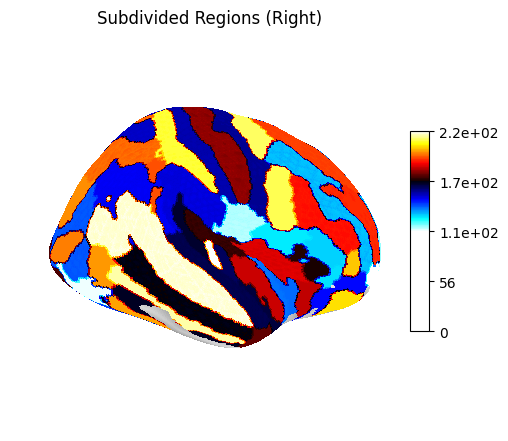

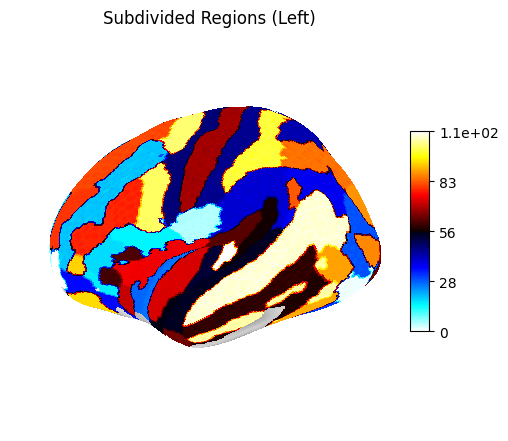

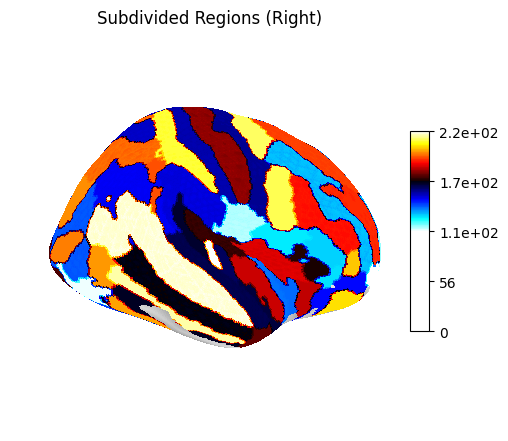

In [38]:
from nilearn import plotting, datasets

region_map = np.full_like(vertex_to_region, fill_value=np.nan, dtype=float)

for i, region_idx in enumerate(subregions):
    region_map[region_idx] = i  # or r2_values[i] if available

region_map_lh = region_map[:len(lh_labels)]
region_map_rh = region_map[len(lh_labels):]

fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')

plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    stat_map=region_map_lh,
    hemi='left',
    title='Subdivided Regions (Left)',
    bg_map=fsaverage.sulc_left,
    colorbar=True
)

plotting.plot_surf_stat_map(
    fsaverage.infl_right,
    stat_map=region_map_rh,
    hemi='right',
    title='Subdivided Regions (Right)',
    bg_map=fsaverage.sulc_right,
    colorbar=True
)


In [44]:
from collections import defaultdict

def build_forecast_window(X_all: np.ndarray, d: int, window_size: int = 7) -> np.ndarray:
    """
    Constructs forecast representations from GPT hidden states.

    Args:
        X_all: [N, D] matrix of GPT hidden states (e.g., one per token)
        d: forecast distance
        window_size: number of tokens in forecast window

    Returns:
        X_forecast: [N, window_size * D] matrix of forecast representations
    """
    N, D = X_all.shape
    X_forecast = []

    for n in range(N):
        indices = [n + d - i for i in reversed(range(window_size))]  # d-6 to d
        if all(0 <= idx < N for idx in indices):
            concat_vec = np.concatenate([X_all[idx] for idx in indices])
            X_forecast.append(concat_vec)
        else:
            X_forecast.append(None)  # will filter these later

    # Filter out None rows
    valid_rows = [i for i, x in enumerate(X_forecast) if x is not None]
    X_valid = np.stack([X_forecast[i] for i in valid_rows])
    return X_valid, valid_rows

X_all = get_gpt2_embeddings(df_contextual, data_params)  # shape: (num_rows_contextual, hidden_dim)
X_forecast_d, valid_idx = build_forecast_window(X_all, d=4)

# Get transcript index of the center word in each forecast window
transcript_idxs = df_contextual.iloc[valid_idx]["transcript_idx"].values

# Compute TR_onset if not present
TR = 1.5
if "TR_onset" not in transcript.columns:
    # Only compute TR_onset for rows with valid onset
    transcript.loc[transcript["onset"].notna(), "TR_onset"] = (transcript.loc[transcript["onset"].notna(), "onset"] // TR).astype(int)
    transcript.loc[transcript["offset"].notna(), "TR_offset"] = (transcript.loc[transcript["offset"].notna(), "offset"] // TR).astype(int)
# Lookup corresponding TRs
TRs = transcript.iloc[transcript_idxs]["TR_onset"].values

# Aggregate X_forecast_d by TR

TR_to_vecs = defaultdict(list)

for x, tr in zip(X_forecast_d, TRs):
    TR_to_vecs[tr].append(x)

X_TR = []
valid_TRs = []
for tr in sorted(set(TRs)):
    if len(TR_to_vecs[tr]) == 0:
        continue
    X_TR.append(np.mean(TR_to_vecs[tr], axis=0))  # average over tokens in TR
    valid_TRs.append(tr)

X_TR = np.stack(X_TR)  # shape: (n_valid_TRs, 7*d_model)

e.g. for a sliding window of 8: 

- window 0: "I", "began", "my", "career", "in", "journalism", "in", "the" → center: career (idx 3)
- window 1: "began", "my", "career", "in", "journalism", "in", "the", "Bronx" → center: in (idx 4)


In [45]:
import matplotlib.pyplot as plt

# align the transcript with the forecast windows
df_contextual_merged = df_contextual.merge(
    transcript[["onset", "offset", "TR_onset", "TR_offset"]],
    left_on="transcript_idx",
    right_index=True,
    suffixes=("", "_transcript")
)

df_contextual_merged["is_valid_center"] = False
df_contextual_merged.loc[valid_idx, "is_valid_center"] = True

df_contextual_merged[["sentence_id", "word_idx", "word", "transcript_idx", "TR_onset", "is_valid_center"]].head(20)

grouped_by_TR = df_contextual_merged[df_contextual_merged["is_valid_center"]].groupby("TR_onset")

# for tr, group in grouped_by_TR:
#     print(f"--- TR {tr} ---")
#     print(group[["word", "sentence_id", "transcript_idx"]])
#     print()


plt.figure(figsize=(10, 4))
df_contextual_merged[df_contextual_merged["is_valid_center"]]["TR_onset"].hist(bins=30)
plt.title("Distribution of valid forecast windows across TRs")
plt.xlabel("TR index")
plt.ylabel("Count")
plt.show()

KeyError: "['TR_offset'] not in index"

## Forecast Scores, Forecast Windows and Forecast Distances

In [52]:
from tqdm import tqdm
import nilearn

forecast_distances = list(range(-4, 5))  # e.g. d ∈ [-4, -3, ..., 4]
brain_scores_by_d = {}

bold_img_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-nosmooth/sub-022/func/sub-022_task-lucy_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz"
brain_mask_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-smooth/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-lucy_desc-brain_mask.nii.gz"
bold = nilearn.image.load_img(bold_img_path)
mask = nilearn.image.load_img(brain_mask_path)
bold = nilearn.masking.apply_mask(bold, mask)

for d in tqdm(forecast_distances, desc="Forecast distance d"):
    X_forecast_d, valid_idx = build_forecast_window(X_all, d=d, window_size=7)

    # Get transcript indices
    transcript_idxs = df_contextual.iloc[valid_idx]["transcript_idx"].values

    # Get TRs
    TRs = transcript.iloc[transcript_idxs]["TR_onset"].values
    TRs = TRs[TRs < bold.shape[0]]

    # Aggregate X per TR
    from collections import defaultdict
    TR_to_vecs = defaultdict(list)
    for x, tr in zip(X_forecast_d, TRs):
        TR_to_vecs[tr].append(x)
    X_TR = []
    valid_TRs = []
    for tr in sorted(set(TR_to_vecs.keys())):
        X_TR.append(np.mean(TR_to_vecs[tr], axis=0))
        valid_TRs.append(tr)
    X_TR = np.stack(X_TR)
    valid_TRs_int = np.array(valid_TRs, dtype=int)
    Y_not_used = bold[valid_TRs_int]  # shape (T, V)
    Y = PCA(n_components=20).fit_transform(Y_not_used)  # shape (T, 20)
    print(f"Forecast distance {d}: X_TR shape: {X_TR.shape}, Y shape: {Y.shape}, Y pre shape {Y_not_used.shape}")

    # Ridge regression
    from sklearn.model_selection import KFold
    from sklearn.linear_model import RidgeCV
    from sklearn.metrics import r2_score

    kf = KFold(n_splits=5)
    alphas = np.logspace(-2, 3, 10)
    voxel_scores = []

    for v in tqdm(range(Y_not_used.shape[1]), leave=False, desc=f"Voxel R² for d={d}"):
        scores = []
        for train_idx, test_idx in kf.split(X_TR):
            X_train, X_test = X_TR[train_idx], X_TR[test_idx]
            y_train, y_test = Y_not_used[train_idx, v], Y_not_used[test_idx, v]
            model = RidgeCV(alphas=alphas)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            scores.append(r2)
        voxel_scores.append(np.mean(scores))

    # Store mean across voxels for distance d
    brain_scores_by_d[d] = voxel_scores

mean_scores = {d: np.mean(scores) for d, scores in brain_scores_by_d.items()}
ds = sorted(mean_scores.keys())
avg_scores = [mean_scores[d] for d in ds]

plt.figure(figsize=(8, 4))
plt.plot(ds, avg_scores, marker='o')
plt.axvline(x=0, linestyle='--', color='gray', label='current word (d=0)')
plt.xlabel("Forecast distance $d$")
plt.ylabel("Mean Brain Score (R²)")
plt.title("Forecast Distance vs Brain Encoding Score")
# plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Forecast distance d:   0%|          | 0/9 [00:00<?, ?it/s]

Forecast distance -4: X_TR shape: (181, 5376), Y shape: (181, 20), Y pre shape (181, 52422)


Forecast distance d:   0%|          | 0/9 [00:29<?, ?it/s]


KeyboardInterrupt: 

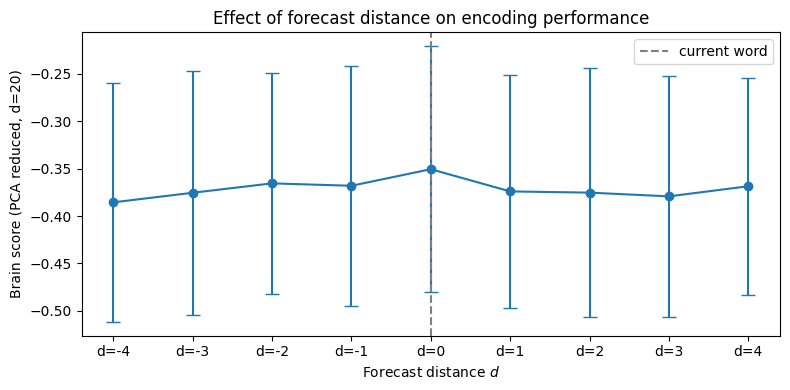

In [50]:
import scipy.stats as stats

ds = sorted(brain_scores_by_d.keys())
means = []
cis = []

for d in ds:
    scores = brain_scores_by_d[d]
    m = np.mean(scores)
    ci = stats.sem(scores) * 1.96  # 95% CI
    means.append(m)
    cis.append(ci)

plt.figure(figsize=(8, 4))
plt.errorbar(ds, means, yerr=cis, fmt='-o', capsize=5)
plt.axvline(x=0, linestyle='--', color='gray', label='current word')
plt.xlabel("Forecast distance $d$")
plt.ylabel("Brain score (PCA reduced, d=20)")
plt.xticks(ds)
plt.xticks(ds, [f"d={d}" for d in ds])
plt.title("Effect of forecast distance on encoding performance")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

This is not working properly, the activations contain for some reason only the first 4 layers of the model, although the `SaveActivationCallback` seems correctly implemented.

Layer indices: [0, 1, 2, 3]


  0%|          | 0/9 [00:00<?, ?it/s]

Processing layer 0 for forecast distance -4
Processing layer 1 for forecast distance -4
Processing layer 2 for forecast distance -4


 11%|█         | 1/9 [00:00<00:05,  1.43it/s]

Processing layer 3 for forecast distance -4
Processing layer 0 for forecast distance -3
Processing layer 1 for forecast distance -3
Processing layer 2 for forecast distance -3
Processing layer 3 for forecast distance -3


 22%|██▏       | 2/9 [00:01<00:05,  1.32it/s]

Processing layer 0 for forecast distance -2
Processing layer 1 for forecast distance -2
Processing layer 2 for forecast distance -2
Processing layer 3 for forecast distance -2


 33%|███▎      | 3/9 [00:02<00:04,  1.32it/s]

Processing layer 0 for forecast distance -1
Processing layer 1 for forecast distance -1
Processing layer 2 for forecast distance -1
Processing layer 3 for forecast distance -1


 44%|████▍     | 4/9 [00:02<00:03,  1.39it/s]

Processing layer 0 for forecast distance 0
Processing layer 1 for forecast distance 0
Processing layer 2 for forecast distance 0


 56%|█████▌    | 5/9 [00:03<00:02,  1.45it/s]

Processing layer 3 for forecast distance 0
Processing layer 0 for forecast distance 1
Processing layer 1 for forecast distance 1
Processing layer 2 for forecast distance 1
Processing layer 3 for forecast distance 1


 67%|██████▋   | 6/9 [00:04<00:02,  1.49it/s]

Processing layer 0 for forecast distance 2
Processing layer 1 for forecast distance 2
Processing layer 2 for forecast distance 2
Processing layer 3 for forecast distance 2


 78%|███████▊  | 7/9 [00:04<00:01,  1.52it/s]

Processing layer 0 for forecast distance 3
Processing layer 1 for forecast distance 3
Processing layer 2 for forecast distance 3
Processing layer 3 for forecast distance 3


 89%|████████▉ | 8/9 [00:05<00:00,  1.48it/s]

Processing layer 0 for forecast distance 4
Processing layer 1 for forecast distance 4
Processing layer 2 for forecast distance 4


100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

Processing layer 3 for forecast distance 4


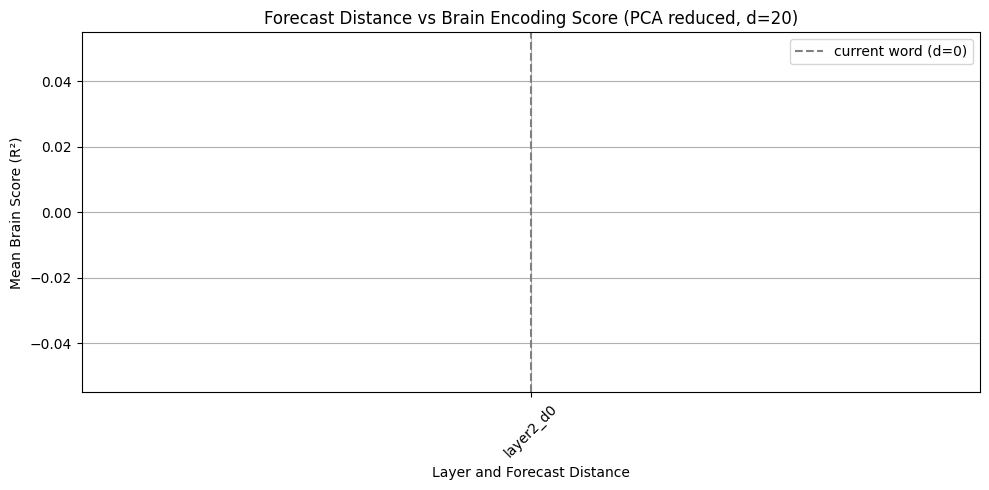

In [ ]:
import torch
from nilearn.image import load_img
from nilearn.masking import apply_mask


# Load logits and activations from the fine-tuned model checkpoint
def load_activations(path):
    data = torch.load(path, map_location="cpu")
    return data["logits"], data["activations"]

# Construct forecast window at distance d for each layer
def build_forecast_window_from_activations(activations, d, window_size=8):
    B, L, T, D = activations.shape
    forecast_by_layer = {}

    for layer in range(L):
        layer_acts = activations[:, layer]  # [B, T, D]
        X_tilde = []
        for t in range(T):
            idxs = [t + d - k for k in reversed(range(window_size))]
            if all(0 <= i < T for i in idxs):
                concat = torch.cat([layer_acts[:, i, :] for i in idxs], dim=-1)
                X_tilde.append(concat)
        if X_tilde:
            forecast_by_layer[layer] = torch.stack(X_tilde).squeeze(1).numpy()
    return forecast_by_layer


# Align forecast windows to fMRI TRs using transcript
def align_forecast_to_TRs(forecast_by_layer, transcript_path, TR=1.5):
    aligned = {}
    df = pd.read_csv(transcript_path, names=["word_orig", "word", "onset", "offset"]).dropna().reset_index(drop=True)
    df["TR_onset"] = (df.onset // TR).astype(int)
    tr_to_idx = df.groupby("TR_onset").first().index.tolist()
    for layer, arr in forecast_by_layer.items():
        if len(tr_to_idx) <= arr.shape[0]:
            aligned[layer] = arr[tr_to_idx]
    return aligned


# Compute encoding (brain) scores using RidgeCV after PCA
def compute_brain_scores(X, bold_img_path, brain_mask_path, pca_components=20, d=None):
    img = load_img(bold_img_path)
    mask = load_img(brain_mask_path)
    Y_not_used = apply_mask(img, mask)
    Y = PCA(n_components=pca_components).fit_transform(Y_not_used)

    kf = KFold(n_splits=5)
    alphas = np.logspace(-2, 3, 10)
    scores = []

    for v in range(Y.shape[1]):
        corr_list = []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = Y[train_idx, v], Y[test_idx, v]

            model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if np.std(y_pred) > 0 and np.std(y_test) > 0:
                corr = np.corrcoef(y_test, y_pred)[0, 1]
            else:
                corr = 0.0
            corr_list.append(corr)
        scores.append(np.mean(corr_list))

    print(f"Forecast score at d={d} computed. Mean score: {np.mean(scores):.4f}")
    return scores


# === Set paths and parameters ===
checkpoint_path = '/home/iustin/predictive-coding-for-fMRI-LM-align-speech/runs/gpt2_alpha_05/checkpoint-19306'
activations_path = os.path.join(checkpoint_path, "activations/eval_activations.pt")
transcript_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/stimuli/gentle/lucy/align.csv"
bold_img_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-nosmooth/sub-022/func/sub-022_task-lucy_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz"
brain_mask_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech/narratives/derivatives/afni-smooth/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-lucy_desc-brain_mask.nii.gz"

logits, activations = load_activations(activations_path)
print("Layer indices:", list(range(activations.shape[1])))
assert activations.ndim == 4  # [B, L, T, D]

# Forecast distances and storage
forecast_distances = list(range(-4, 5))
brain_scores_by_d = {}

# === Main loop ===
for d in tqdm(forecast_distances):
    forecast_by_layer = build_forecast_window_from_activations(activations, d=d, window_size=8)
    aligned_forecast_by_layer = align_forecast_to_TRs(forecast_by_layer, transcript_path, TR=1.5)

    for layer, forecast_window in aligned_forecast_by_layer.items():
        brain_scores = compute_brain_scores(forecast_window, bold_img_path, brain_mask_path, pca_components=20, d=d)
        key = f"layer{layer}_d{d}"
        brain_scores_by_d[key] = brain_scores

# === Plotting results ===
mean_scores = {k: np.mean(v) for k, v in brain_scores_by_d.items()}
ds = sorted(mean_scores.keys(), key=lambda x: (int(x.split('_d')[-1]), int(x.split('layer')[1].split('_')[0])))
avg_scores = [mean_scores[d] for d in ds]

plt.figure(figsize=(10, 5))
plt.plot(ds, avg_scores, marker='o')
plt.axvline(x='layer2_d0', linestyle='--', color='gray', label='current word (d=0)')
plt.xlabel("Layer and Forecast Distance")
plt.ylabel("Mean Brain Score (R²)")
plt.title("Forecast Distance vs Brain Encoding Score (PCA reduced, d=20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from nilearn.masking import apply_mask
from nilearn.image import load_img
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_forecast_score(X, X_tilde_d, Y, transcript, TR=1.5, n_pca=20):
    transcript = transcript.dropna().reset_index(drop=True)
    transcript["transcript_idx"] = np.arange(len(transcript))
    transcript["TR_onset"] = (transcript.onset // TR).astype(int)
    TRs = sorted(transcript.TR_onset.unique())

    def group_by_TR(matrix, transcript, TRs):
        vecs = []
        for tr in TRs:
            indices = transcript.loc[transcript.TR_onset == tr, "transcript_idx"].to_numpy()
            if len(indices) > 0 and np.max(indices) < matrix.shape[0]:
                vecs.append(matrix[indices].mean(axis=0))
        return np.stack(vecs)

    X_TR = group_by_TR(X, transcript, TRs)
    X_tilde_TR = group_by_TR(X_tilde_d, transcript, TRs)

    # === Align lengths ===
    min_len = min(len(X_TR), len(X_tilde_TR), len(Y))

    X_TR = X_TR[:min_len]
    X_tilde_TR = X_tilde_TR[:min_len]
    Y = Y[:min_len]
    print(f"Aligned lengths: X_TR: {len(X_TR)}, X_tilde_TR: {len(X_tilde_TR)}, Y: {len(Y)}")

    X_pca = PCA(n_components=n_pca).fit_transform(X_TR)
    X_concat = np.concatenate([X_TR, X_tilde_TR], axis=1)
    X_concat_pca = PCA(n_components=n_pca).fit_transform(X_concat)

    min_len = min(len(X_pca), Y.shape[0])
    X_pca, X_concat_pca, Y = X_pca[:min_len], X_concat_pca[:min_len], Y[:min_len]

    def ridge_score(X, Y):
        kf = KFold(n_splits=5)
        alphas = np.logspace(-2, 3, 10)
        scores = []
        for v in range(Y.shape[1]):
            y = Y[:, v]
            corr_list = []
            for train, test in kf.split(X):
                model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
                model.fit(X[train], y[train])
                y_pred = model.predict(X[test])
                if np.std(y_pred) > 0 and np.std(y[test]) > 0:
                    corr = np.corrcoef(y[test], y_pred)[0, 1]
                else:
                    corr = 0.0
                corr_list.append(corr)
            scores.append(np.mean(corr_list))
        return np.array(scores)

    score_X = ridge_score(X_pca, Y)
    score_X_tilde = ridge_score(X_concat_pca, Y)

    return score_X_tilde - score_X, np.mean(score_X_tilde - score_X)

# === Parameters ===
task = "lucy"
forecast_distances = list(range(-4, 5))
layer_to_use = 8
TR = 1.5
n_pca = 20
base_path = "/home/iustin/predictive-coding-for-fMRI-LM-align-speech"
output_dir = os.path.join(base_path, "gpt2_vanilla_representations")

# === Load data ===
with open(f"{output_dir}/representations_gpt2_ws8_{task}.pkl", "rb") as f:
    X = pickle.load(f)["ws_8"]

with open(f"{base_path}/gpt2_ft_representations/forecast_layer{layer_to_use}_{task}.pkl", "rb") as f:
    X_tilde_all = pickle.load(f)

transcript_path = f"{base_path}/narratives/stimuli/gentle/{task}/align.csv"
transcript = pd.read_csv(transcript_path, names=["word_orig", "word", "onset", "offset"])

bold_img_path = f"{base_path}/narratives/derivatives/afni-nosmooth/sub-022/func/sub-022_task-{task}_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz"
mask_path = f"{base_path}/narratives/derivatives/afni-smooth/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-{task}_desc-brain_mask.nii.gz"
Y = apply_mask(load_img(bold_img_path), load_img(mask_path))

# === Compute forecast scores across distances ===
mean_scores = {}
for d in tqdm(forecast_distances, desc="Computing ΔR²"):
    X_tilde_d = X_tilde_all[f"d={d}"]
    _, mean_score = compute_forecast_score(X, X_tilde_d, Y, transcript, TR=TR, n_pca=n_pca)
    mean_scores[d] = mean_score
    print(f"d = {d}: ΔR² = {mean_score:.4f}")

# === Plot ===
ds = sorted(mean_scores.keys())
avg_scores = [mean_scores[d] for d in ds]

Computing ΔR²:   0%|          | 0/9 [00:00<?, ?it/s]

Aligned lengths: X_TR: 336, X_tilde_TR: 336, Y: 336


Computing ΔR²:  11%|█         | 1/9 [09:08<1:13:04, 548.11s/it]

d = -4: ΔR² = 0.0065
Aligned lengths: X_TR: 336, X_tilde_TR: 336, Y: 336


Computing ΔR²:  22%|██▏       | 2/9 [18:14<1:03:50, 547.25s/it]

d = -3: ΔR² = 0.0064
Aligned lengths: X_TR: 336, X_tilde_TR: 336, Y: 336


Computing ΔR²:  33%|███▎      | 3/9 [27:24<54:49, 548.27s/it]  

d = -2: ΔR² = 0.0063
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²:  44%|████▍     | 4/9 [36:29<45:35, 547.06s/it]

d = -1: ΔR² = 0.0090
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²:  56%|█████▌    | 5/9 [45:32<36:22, 545.57s/it]

d = 0: ΔR² = 0.0092
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²:  67%|██████▋   | 6/9 [54:35<27:14, 544.71s/it]

d = 1: ΔR² = 0.0092
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²:  78%|███████▊  | 7/9 [1:03:37<18:07, 543.82s/it]

d = 2: ΔR² = 0.0094
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²:  89%|████████▉ | 8/9 [1:12:41<09:03, 543.80s/it]

d = 3: ΔR² = 0.0094
Aligned lengths: X_TR: 337, X_tilde_TR: 337, Y: 337


Computing ΔR²: 100%|██████████| 9/9 [1:21:43<00:00, 544.84s/it]

d = 4: ΔR² = 0.0091


NameError: name 'plt' is not defined

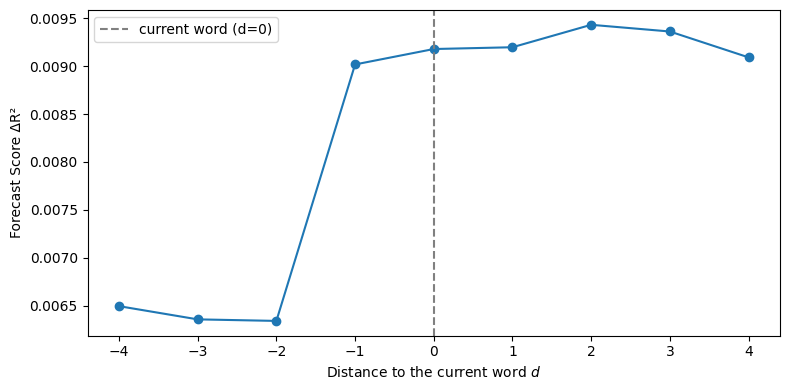

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(ds, avg_scores, marker='o')
plt.axvline(x=0, linestyle='--', color='gray', label='current word (d=0)')
plt.xlabel("Distance to the current word $d$")
plt.ylabel("Forecast Score ΔR²")
# plt.title("Forecast Distance vs Brain Encoding Gain")
# plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()